# Test EVI Forecast (local)

In [1]:
# System Imports
import json
import pickle
import os
import requests
from datetime import datetime,timedelta

#3rd Party Imports
import numpy as np
import pandas as pd
import rasterio
import tensorflow as tf
from azure.identity import ClientSecretCredential
from tensorflow import keras


# Local Imports
from azure.farmbeats.models import Farmer, Boundary, Polygon, SatelliteIngestionJobRequest, WeatherIngestionJobRequest
from azure.farmbeats import FarmBeatsClient
from utils.config import farmbeats_config
from utils.weather_util import WeatherUtil
from utils.satellite_util import SatelliteUtil
from utils.constants import CONSTANTS
from utils.ard_util import ard_preprocess

# Disable unnecessary logs
import sys
import logging
logging.disable(sys.maxsize)

### Farmbeats Configuration

In [2]:
# FarmBeats Client definition
credential = ClientSecretCredential(
    tenant_id="e21b7e4f-4b6c-4ead-bb26-b615da83f381",
    client_id="640027d7-3e96-49fc-8ecf-775f47a1e7b8",
    client_secret="rC.NHz~YPJn_xKGMh-OTg3M4P2kn6EbI90",
    authority="https://login.windows-ppe.net"
)

credential_scopes = ["https://farmbeats-dogfood.azure.net/.default"]

fb_client = FarmBeatsClient(
    base_url="https://agadhibjs-one.farmbeats-dogfood.azure.net",
    credential=credential,
    credential_scopes=credential_scopes,
    logging_enable=True
)

### Forecast EVI for test Boundary

#### Satellite Data

In [3]:
farmer_id = "annam_farmer"
boundary_id = "boundary055"

end_dt = datetime.strptime(datetime.now().strftime("%Y-%m-%d"), "%Y-%m-%d")
start_dt = end_dt - timedelta(days=60)

# get boundary object
boundary = fb_client.boundaries.get(
            farmer_id=farmer_id,
            boundary_id=boundary_id
        )

root_dir = "C:\\farmbeats\\"

In [4]:
sat_links1 = SatelliteUtil(farmbeats_client = fb_client).download_and_get_sat_file_paths(farmer_id, [boundary], start_dt, end_dt, root_dir)

# get last available data of satellite data
end_dt_w = datetime.strptime(
    sat_links1.sceneDateTime.sort_values(ascending=False).values[0][:10], "%Y-%m-%d"
)
# calculate 30 days from last satellite available date
start_dt_w = end_dt_w - timedelta(days=CONSTANTS["input_days"] + 1)

Finished Downloading!!


C:\azure-farmbeats-samples\evi_forecast\utils\satellite_util.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ).name.transform(len)
C:\azure-farmbeats-samples\evi_forecast\utils\satellite_util.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for x in df_allscenes_band.fileLink.values


#### Weather Data

In [5]:
# get weather data historical
weather_list = fb_client.weather.list(
            farmer_id=  boundary.farmer_id,
            boundary_id= boundary.id,
            start_date_time=start_dt_w,
            end_date_time=end_dt,
            extension_id="dtn.clearAg", 
            weather_data_type= "historical", 
            granularity="daily")
weather_data = []
for w_data in weather_list:
    weather_data.append(w_data)
w_df_hist = WeatherUtil.get_weather_data_df(weather_data)

C:\azure-farmbeats-samples\evi_forecast\utils\weather_util.py:26: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df_flat = pd.io.json.json_normalize([x.serialize() for x in weather_data])


In [6]:
# get weather data forecast
weather_list = fb_client.weather.list(
            farmer_id=  boundary.farmer_id,
            boundary_id= boundary.id,
            start_date_time=end_dt,
            end_date_time=end_dt + timedelta(10),
            extension_id="dtn.clearAg", 
            weather_data_type= "forecast", 
            granularity="daily")

weather_data = []
for w_data in weather_list:
    weather_data.append(w_data)
w_df_forecast = WeatherUtil.get_weather_data_df(weather_data)

In [7]:
# merge weather data
w_df = pd.concat([w_df_hist, w_df_forecast], axis=0)

with open(CONSTANTS["w_pkl"], "rb") as f:
    w_parms, w_mn, w_sd = pickle.load(f)

In [8]:
ard = ard_preprocess(
        sat_links1=sat_links1,
        w_df=w_df,
        sat_res_x=1,
        var_name=CONSTANTS["var_name"],
        interp_date_start=end_dt_w - timedelta(days=60),
        interp_date_end=end_dt_w,
        w_parms=w_parms,
        input_days=CONSTANTS["input_days"],
        output_days=CONSTANTS["output_days"],
        ref_tm=start_dt_w.strftime("%d-%m-%Y"),
        w_mn=w_mn,
        w_sd=w_sd,
    )

frcst_st_dt  = end_dt_w

C:\azure-farmbeats-samples\evi_forecast\utils\ard_util.py:148: RuntimeWarning: All-NaN slice encountered
  np.nanmax(np.abs(np.array(da3.input_evi.to_list())), axis=(1, 2)) <= 1
C:\azure-farmbeats-samples\evi_forecast\utils\ard_util.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  np.nanmax(np.abs(np.array(da3.input_evi.to_list())), axis=(1, 2)) <= 1
C:\azure-farmbeats-samples\evi_forecast\utils\ard_util.py:151: RuntimeWarning: All-NaN slice encountered
  np.nanmax(np.abs(np.array(da3.output_evi.to_list())), axis=(1, 2)) <= 1
C:\azure-farmbeats-samples\evi_forecast\utils\ard_util.py:151: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

In [9]:
# raise exception if ARD is empty
if ard.shape[0] == 0:
    raise Exception("Analysis ready dataset is empty")
# raise exception if data spills into multiple rows
if ard.query("grp1_ > 0").shape[0] > 0:
    raise Exception(
        "More than one record has been found for more than one pixel"
    )
# warning if nans are in input data or data is out of bounds
if (
    ard.query("not nan_input_evi").shape[0] > 0
    or ard.query("not nan_input_w").shape[0] > 0
    or ard.query("not nan_output_w").shape[0] > 0
):
    print("Warning: NaNs found in the input data")
if (
    ard.query(
        "nan_input_evi and nan_input_w and nan_output_w and  not input_evi_le1"
    ).shape[0]
    > 0
):
    print("Warning: input data outside range of (-1,1) found")

In [10]:
# read model and weather normalization stats
model = tf.keras.models.load_model(CONSTANTS["modelh5"], compile=False)

In [11]:
# model prediction
label = model.predict(
    [
        np.array(ard.input_evi.to_list()),
        np.array(ard.input_weather.to_list()),
        np.array(ard.forecast_weather.to_list()),
    ]
)
label_names = [
    (frcst_st_dt + timedelta(days=i + 1)).strftime("%Y-%m-%d")
    for i in range(CONSTANTS["output_days"])
]


tmp_df = pd.DataFrame(label[:, :, 0], columns=label_names).assign(
    lat=ard.lat_.values, long=ard.long_.values
)

In [12]:
tmp_df

,2021-04-23,2021-04-24,2021-04-25,2021-04-26,2021-04-27,2021-04-28,2021-04-29,2021-04-30,2021-05-01,2021-05-02,lat,long
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-97.065187,46.659102
1,0.061157,0.096995,0.132223,0.145768,0.156944,0.162661,0.166236,0.164669,0.161892,0.161764,-97.065187,46.659193
2,0.058901,0.093092,0.127034,0.139777,0.150345,0.155724,0.159159,0.157608,0.154843,0.154517,-97.065187,46.659283
3,0.052682,0.082350,0.112763,0.123313,0.132219,0.136679,0.139736,0.138236,0.135510,0.134646,-97.065187,46.659373
4,0.057619,0.090875,0.124088,0.136376,0.146599,0.151786,0.155141,0.153600,0.150842,0.150403,-97.065187,46.659463
...,...,...,...,...,...,...,...,...,...,...,...,...
12007,0.066766,0.106699,0.145121,0.160647,0.173324,0.179866,0.183782,0.182171,0.179365,0.179723,-97.057108,46.670567
12008,0.066766,0.106699,0.145121,0.160647,0.173324,0.179866,0.183782,0.182171,0.179365,0.179723,-97.057108,46.670657
12009,0.066338,0.105956,0.144132,0.159504,0.172064,0.178541,0.182428,0.180820,0.178015,0.178334,-97.057108,46.670747
12010,0.062674,0.099610,0.135693,0.149759,0.161328,0.167256,0.170915,0.169332,0.166544,0.166540,-97.057108,46.670837


### Write output to TIF files

In [13]:
%matplotlib inline
import time
from IPython import display
from rasterio.plot import show

output_dir = "results//"
ref_tif = sat_links1.filePath.values[0]
with rasterio.open(ref_tif) as src:
    ras_meta = src.profile

In [14]:
for coln in tmp_df.columns[:-2]:
    data_array = np.array(tmp_df[coln]).reshape(src.shape)
    with rasterio.open(os.path.join(output_dir, coln + '.tif'), 'w', **ras_meta) as dst:
        dst.write(data_array, indexes=1)

### Visualize EVI Forecast Maps

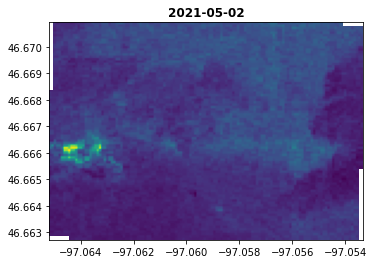

In [15]:
for coln in tmp_df.columns[:-2]:
    src = rasterio.open(os.path.join(output_dir, coln + '.tif'))
    show(src.read(), transform=src.transform, title=coln)
    #show_hist(src)
    display.clear_output(wait=True)
    time.sleep(1)  